In [1]:
import gzip
import json
import pickle
import scipy.sparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from scipy import spatial
from tqdm.auto import tqdm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8dxofspm because the default path (/home/i313924/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
THREADS = 8

In [3]:
model = pd.read_pickle('/pio/scratch/1/i313924/lightfm_data/warp_model_300_epochs_200_el_slim.pkl')

## Precision

In [6]:
interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/lightfm_data/slim_interactions.npz')

In [ ]:
# Super time-consuming: https://github.com/lyst/lightfm/issues/510
precision_at_k(model, interactions, k=5, num_threads=THREADS).mean()

## ABX

In [4]:
dataset = pd.read_pickle('/pio/scratch/1/i313924/lightfm_data/slim_dataset.pkl')
abx_tests = pd.read_json('/pio/scratch/1/i313924/test_ABX_slim', lines=True)

In [5]:
abx_tests

,A,B,X,category_AX,category_B
0,B00W9QTX3S,B00QKHWXOS,B00STZXEV0,Women,Girls
1,B00I7Q52NE,B00KAGTK2S,B00178M5M0,Luggage & Travel Gear,Novelty & More
2,B00N9HXOAE,B00RSWNGPO,B000NJQU2A,Men,Novelty & More
3,B00H7SBIAO,B01DAL9I6W,B004N639D2,Boys,Women
4,B0078IRRSA,B00EW148GU,B0035P3V0I,Women,Girls
...,...,...,...,...,...
9995,B00QG6OV20,B002MPPV8W,B0136IOUCG,Boys,Men
9996,B00JKS0QJ8,B00C766FY0,B00CIBECSA,Women,Novelty & More
9997,B007IVAC7U,B00CBSVT5E,B00BEKARM6,Novelty & More,Luggage & Travel Gear
9998,B00KTYKL0G,B010UPVKF8,B01E1S94LM,Men,Women


In [6]:
def get_item_embedding(model, dataset, asin):
    item_id = dataset.mapping()[2][asin]
    return model.item_embeddings[item_id]

In [9]:
A = np.zeros((10000, 200))
B = np.zeros((10000, 200))
X = np.zeros((10000, 200))

In [10]:
for i, test in tqdm(abx_tests.iterrows()):
    A[i, :] = get_item_embedding(model, dataset, test["A"])
    B[i, :] = get_item_embedding(model, dataset, test["B"])
    X[i, :] = get_item_embedding(model, dataset, test["X"])

0it [00:00, ?it/s]

In [11]:
dist_A = ((A - X)**2).sum(axis=1)
dist_B = ((B - X)**2).sum(axis=1)

In [12]:
(dist_A < dist_B).mean()

0.5205

In [13]:
cos_dist_A = np.zeros(10000)
cos_dist_B = np.zeros(10000)
for i in tqdm(range(10000)):
    cos_dist_A[i] = spatial.distance.cosine(A[i, :], X[i, :])
    cos_dist_B[i] = spatial.distance.cosine(B[i, :], X[i, :])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
(cos_dist_A < cos_dist_B).mean()

0.5729

## Embeddings PCA

In [15]:
item_embeddings = pd.DataFrame(model.item_embeddings)
user_embeddings = pd.DataFrame(model.user_embeddings)

In [16]:
embeddings = pd.concat([item_embeddings, user_embeddings], keys=['items', 'users'])

In [17]:
embeddings.loc["items"]

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.099631,-0.129008,-0.036016,0.005940,0.011543,-0.053696,0.001421,0.085326,-0.032767,0.009495,...,-0.113700,0.032587,0.045365,0.018275,-0.070602,0.053020,-0.011591,-0.047260,-0.081577,0.092697
1,0.382586,0.077787,0.103413,0.197934,-0.142547,0.045930,0.020521,0.129377,-0.268965,0.091963,...,0.245693,0.142344,-0.007857,0.197788,0.009218,-0.147377,0.093936,0.308285,-0.049768,-0.037625
2,-0.117521,-0.266051,0.041075,0.362857,-0.010904,0.374578,-0.001071,-0.059151,0.160152,0.192014,...,0.392301,-0.051974,-0.736700,0.098228,0.046143,0.403104,0.066242,0.207378,-0.046307,0.360108
3,-0.594742,0.119968,0.001045,-0.135156,-0.261969,-0.239729,0.427492,-0.010368,-0.022392,0.194704,...,-0.396340,-0.165379,-0.829949,-0.244940,0.482253,-0.212534,0.053390,0.480961,-0.196772,-0.031204
4,-0.080375,-0.151439,0.109643,-0.002314,-0.017234,-0.023862,-0.150034,0.170244,0.242957,0.144348,...,-0.245867,-0.051538,-0.027030,0.187130,0.027428,-0.081220,-0.062875,-0.298247,-0.385214,-0.156252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206491,0.013364,-0.017793,-0.006946,-0.017329,-0.084526,-0.049113,-0.044960,-0.130461,0.015339,0.110704,...,-0.028519,-0.049916,-0.004845,0.225347,-0.018819,0.204910,0.043209,-0.212666,-0.038951,0.097974
206492,-0.234671,-0.101826,0.049827,-0.349116,0.109446,-0.050665,0.233808,0.277467,-0.007895,-0.195998,...,-0.003775,0.063544,-0.183109,0.111637,0.115501,-0.173634,-0.144409,0.122479,-0.234141,-0.042942
206493,-0.237177,-0.067635,0.461634,-0.088949,0.095725,0.002909,-0.144310,0.171478,0.157871,0.080070,...,-0.071775,-0.051303,-0.042610,-0.007517,-0.124452,0.017865,0.042811,0.062004,-0.018038,0.027903
206494,-0.204668,-0.091221,0.028568,-0.105684,0.111227,-0.201148,-0.112549,-0.322548,-0.033792,0.060812,...,0.094282,-0.079979,0.227169,0.118716,-0.123920,-0.267944,-0.385432,-0.120508,-0.117952,-0.056010


In [18]:
pca = PCA(n_components=2)
pca.fit(embeddings)

PCA(n_components=2)

In [19]:
reduced_item_embeddings = pd.DataFrame(pca.transform(embeddings.loc["items"]))
reduced_user_embeddings = pd.DataFrame(pca.transform(embeddings.loc["users"]))

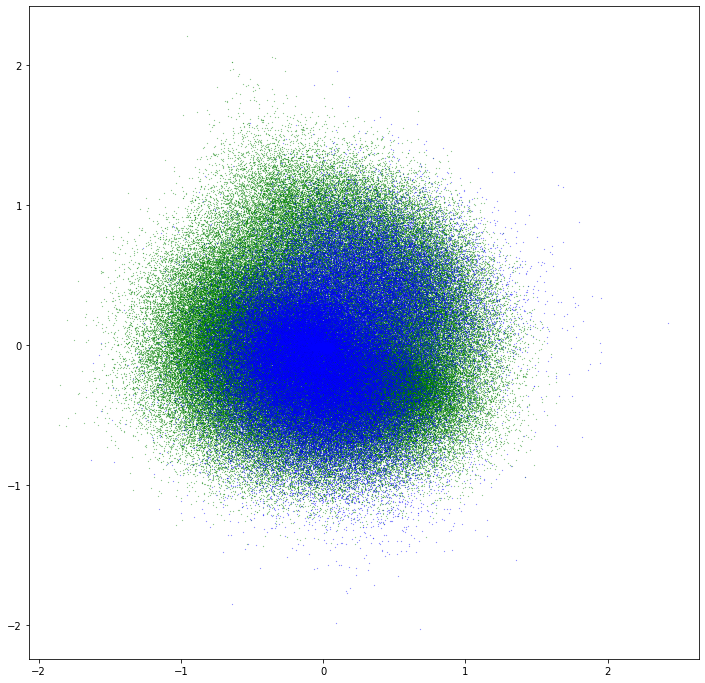

In [20]:
plt.figure(figsize=(12, 12))
plt.scatter(reduced_item_embeddings[0], reduced_item_embeddings[1], c='green', s=0.03)
plt.scatter(reduced_user_embeddings[0], reduced_user_embeddings[1], c='blue', s=0.03)

In [21]:
reduced_item_embeddings

,0,1
0,0.761012,-0.354308
1,0.089202,0.235172
2,0.049179,0.590517
3,-0.793310,-0.108760
4,-0.061538,-0.454355
...,...,...
206491,0.699340,-0.738661
206492,0.652741,-0.682808
206493,-0.389478,-0.696592
206494,0.294774,0.219445


In [22]:
item_mapping = {v: k for k, v in dataset.mapping()[2].items()}
user_mapping = {v: k for k, v in dataset.mapping()[0].items()}

In [23]:
reduced_item_embeddings = reduced_item_embeddings.rename(index=item_mapping)

In [24]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [25]:
reduced_item_embeddings = reduced_item_embeddings.join(categories.set_index('asin'))

In [26]:
reduced_item_embeddings.columns = ['0', '1', 'category_1', 'category_2']

<AxesSubplot:xlabel='0', ylabel='1'>

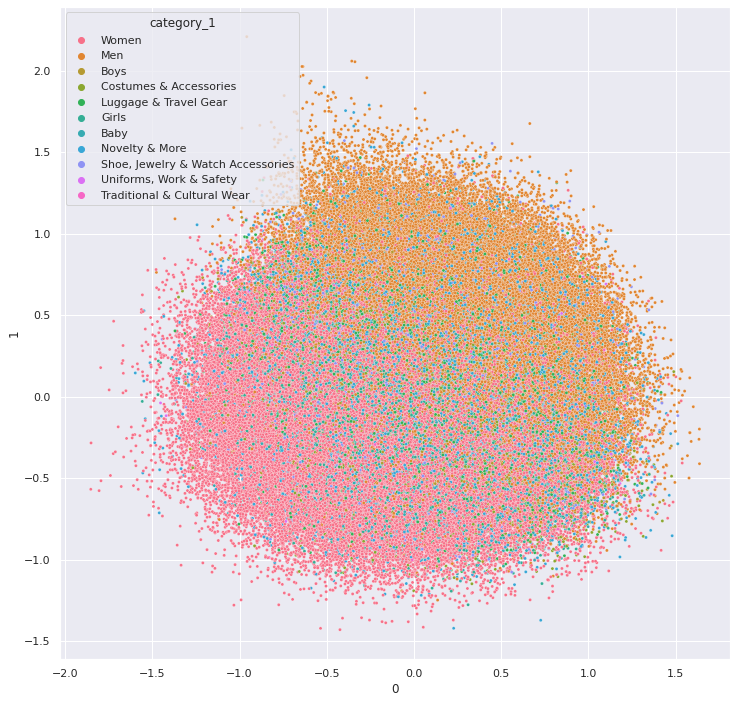

In [27]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings, hue='category_1', s=10)

<AxesSubplot:xlabel='0', ylabel='1'>

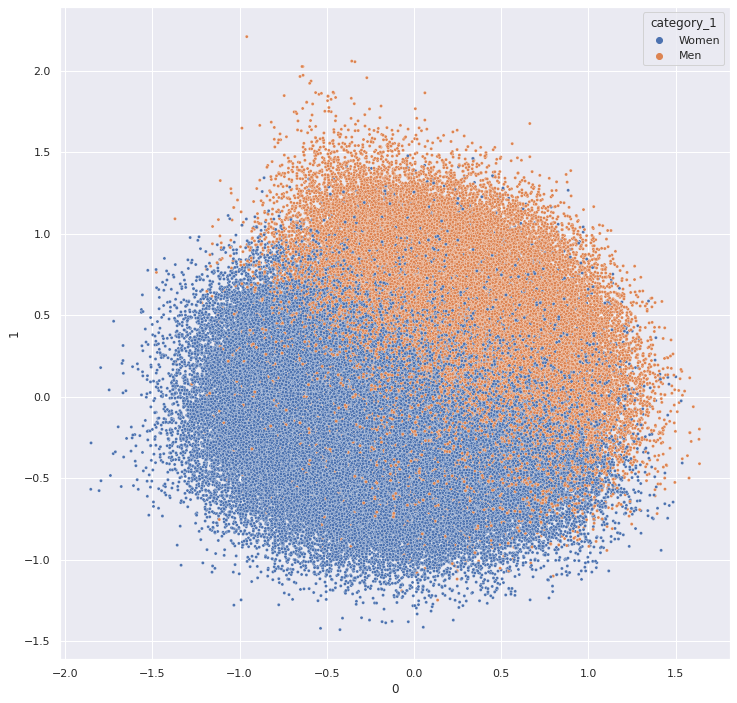

In [28]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Women', 'Men'])], hue='category_1', s=10)